### About the Dataset
DeFungi is a dataset containing 9000+ microscopic fungi images. The images are from superficial fungal infections (estimated to affect around 1 billion people worldwide) caused by yeasts, moulds or dermatophyte fungi.

The images are labelled into five classes (representing five fungi types), and cropped to the region of interest.

Source: [Dataset](https://archive.ics.uci.edu/dataset/773/defungi), [Paper](https://arxiv.org/abs/2109.07322)

In [1]:
from fastai.vision.all import *

### Exploratory Data Analysis

In [2]:
path = Path()
data_path = path/'data/defungi'

images = get_image_files(data_path)
print(f"No. of images: {len(images)}")

No. of images: 9114


In [3]:
# ensure all images are 500x500px
sizes = set(Image.open(img).size for img in images)
print("Image Dimensions:", *sizes)

Image Dimensions: (500, 500)


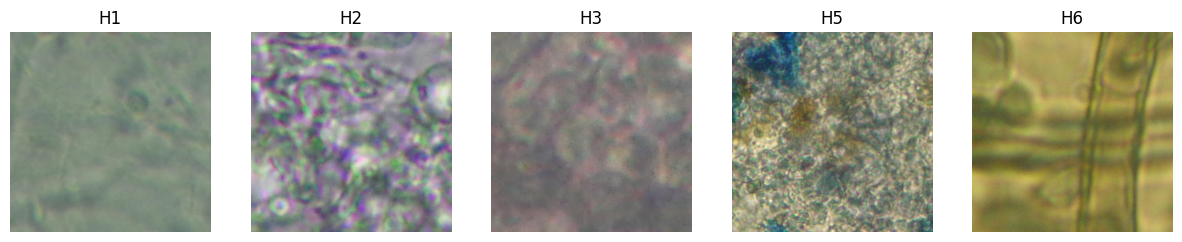

In [7]:
# preview a random image from each class
images = []
target = []
counts = []
for path in data_path.ls().sorted():
    target.append(path.name) # class name is name of parent folder

    class_images = get_image_files(path)
    counts.append(len(class_images))

    img = random.choice(class_images)
    images.append(Image.open(img))

show_images(images, titles=target)

Text(0, 0.5, 'Count')

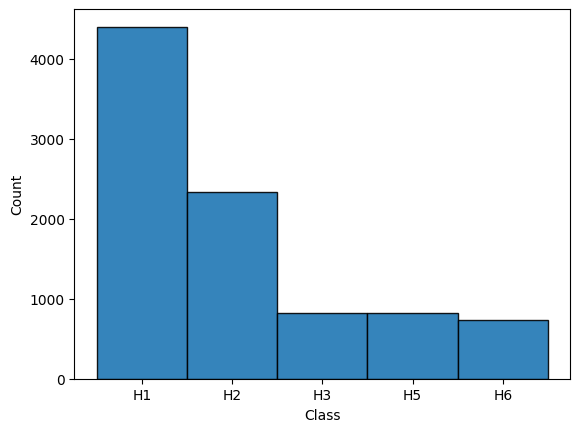

In [8]:
# distribution of classes
plt.bar(target, counts, width=1, edgecolor='black', alpha=0.9)
plt.xlabel('Class')
plt.ylabel('Count')

### Preprocessing

Clearly, the data has imbalanced class proportions.  
To ensure that our training and validation sets have the same class proportions, we will split the data using stratified sampling.

In [9]:
labels = [parent_label(img) for img in get_image_files(data_path)]
splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

By default, the model will see the same image multiple times, once for each epoch.  
To avoid overfitting, we will transform the image slightly each time using `aug_transforms`.

In [10]:
# size=224 since that's what the Resnet34 model expects
batch_transforms = aug_transforms(size=224, p_affine=0, max_warp=0, flip_vert=True)

# required if using an Apple Silicon chip, to avoid "RuntimeError: Adaptive pool MPS: input sizes must be divisible by output sizes"
# 448 = 2*224 which circumvents the issue
item_transforms = Resize(448, method='squish')

In [11]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=splitter,
    get_y=parent_label,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms
)
dls = dblock.dataloaders(data_path, batch_size=32)

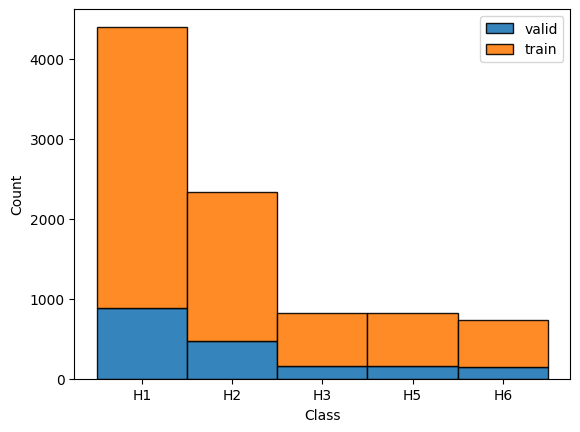

In [12]:
# check distributions of train and validation set
from collections import Counter

train_labels = sorted(parent_label(x) for x in dls.train.items)
valid_labels = sorted(parent_label(x) for x in dls.valid.items)
ntrain = list(Counter(train_labels).values())
nvalid = list(Counter(valid_labels).values())

ax = plt.subplots()[1]
ax.bar(target, nvalid, width=1, edgecolor='black', alpha=0.9, label='valid')
ax.bar(target, ntrain, width=1, edgecolor='black', alpha=0.9, label='train', bottom=nvalid)
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()

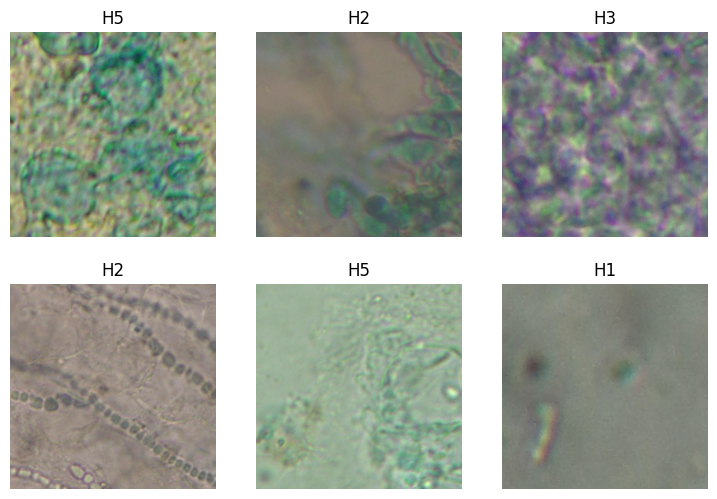

In [34]:
dls.show_batch(max_n=6, nrows=2)

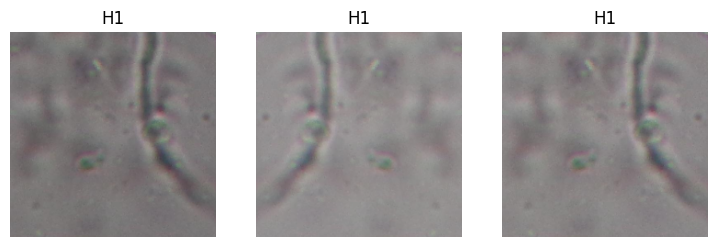

In [35]:
# unique=True will show the same image each time, allowing us to see what effect aug_transforms has on the image
dls.show_batch(max_n=3, nrows=1, unique=True)

### Model Training

In [36]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(valley=0.0014454397605732083)

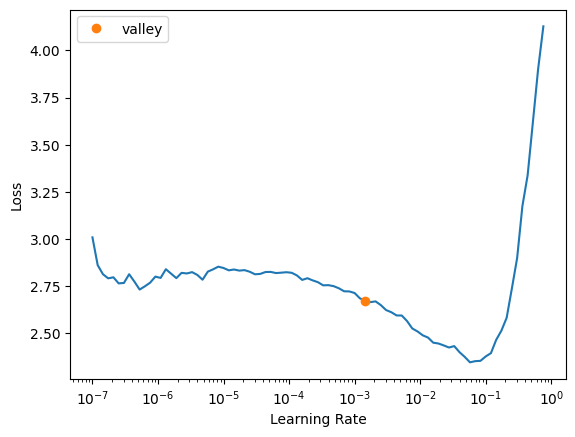

In [37]:
learn.lr_find()

In [38]:
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.270077,0.803043,0.291827,0.708173,02:55


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.852031,0.557769,0.226550,0.773450,04:16
1,0.654166,0.504141,0.199671,0.800329,04:41
2,0.573558,0.423004,0.171695,0.828305,05:33
3,0.501587,0.377630,0.144268,0.855732,05:51
4,0.471561,0.359510,0.143171,0.856829,06:04
5,0.376516,0.278649,0.099835,0.900165,06:17
6,0.307577,0.286206,0.105869,0.894131,06:24
7,0.226385,0.243994,0.090510,0.909490,06:31
8,0.200771,0.230244,0.076796,0.923204,06:22
9,0.150314,0.225781,0.077894,0.922106,06:43


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

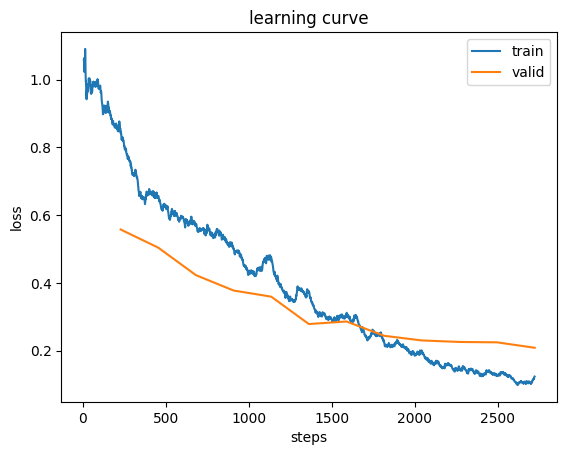

In [39]:
learn.recorder.plot_loss()

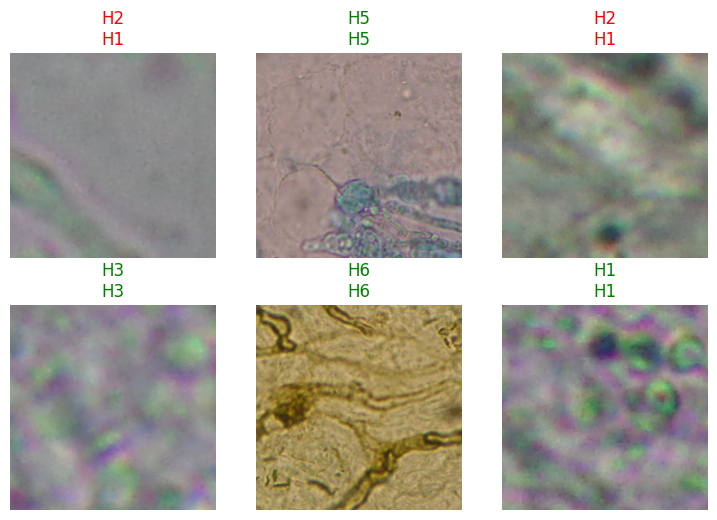

In [40]:
learn.show_results(max_n=6, nrows=2)

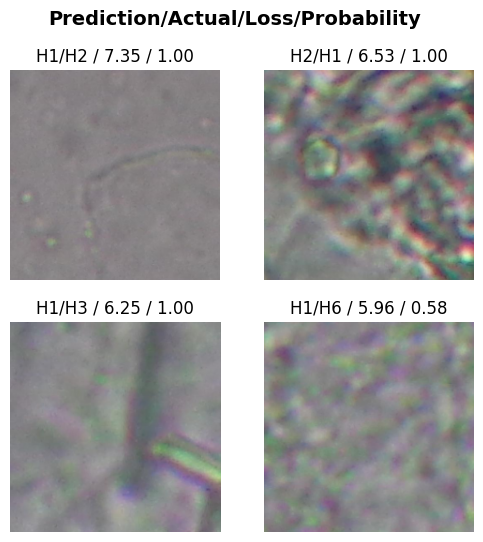

In [41]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(4)

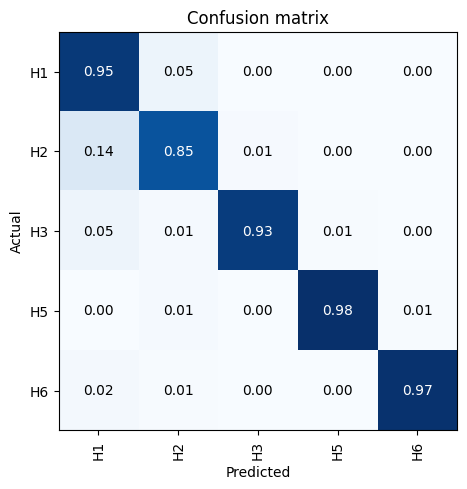

In [42]:
# show confusion matrix of predictions on the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

#### ViT Tiny

In [43]:
learn = vision_learner(dls, 'vit_tiny_patch16_224', metrics=[error_rate, accuracy])
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(valley=0.001737800776027143)

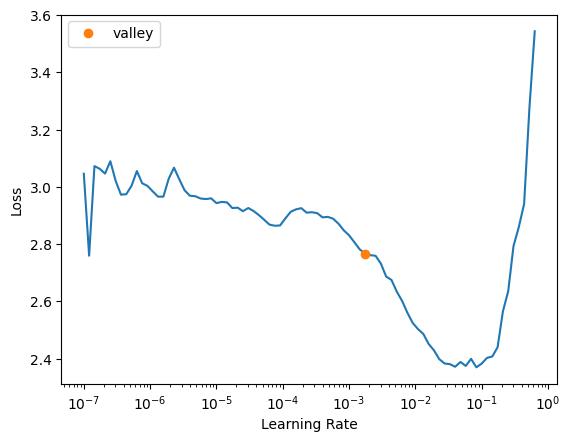

In [44]:
learn.lr_find()

In [45]:
learn.fine_tune(12, 0.006)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.039154,0.727297,0.283050,0.716950,03:25


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.719094,0.504400,0.206802,0.793198,04:37
1,0.584962,0.463776,0.190346,0.809654,04:37
2,0.559346,0.476631,0.181569,0.818431,04:38
3,0.550887,0.470663,0.183214,0.816786,04:46
4,0.448200,0.421624,0.169501,0.830499,04:43
5,0.399831,0.421704,0.188700,0.811300,04:39
6,0.310420,0.420568,0.150302,0.849698,05:00
7,0.263457,0.329620,0.114646,0.885354,05:00
8,0.213895,0.289430,0.100384,0.899616,05:08
9,0.180563,0.272374,0.094899,0.905101,05:17


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

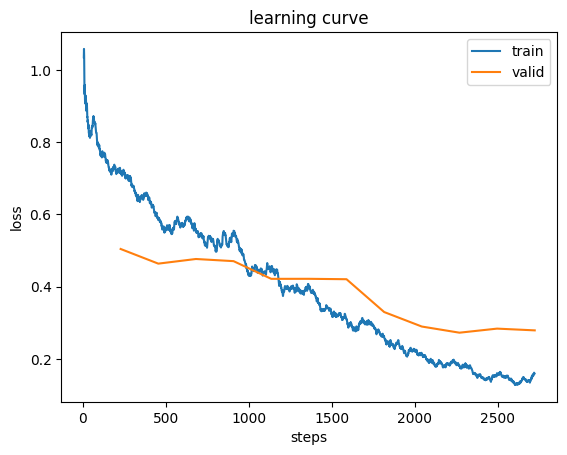

In [46]:
learn.recorder.plot_loss()

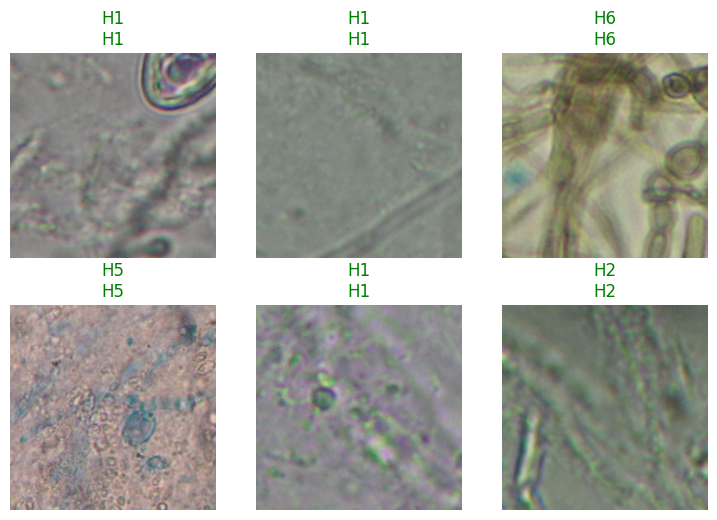

In [47]:
learn.show_results(max_n=6, nrows=2)

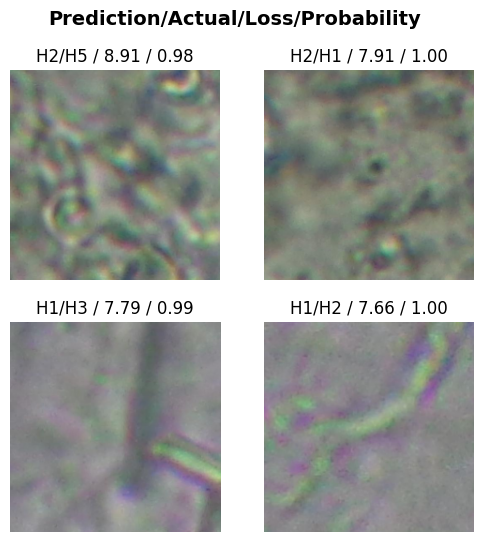

In [48]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(4)

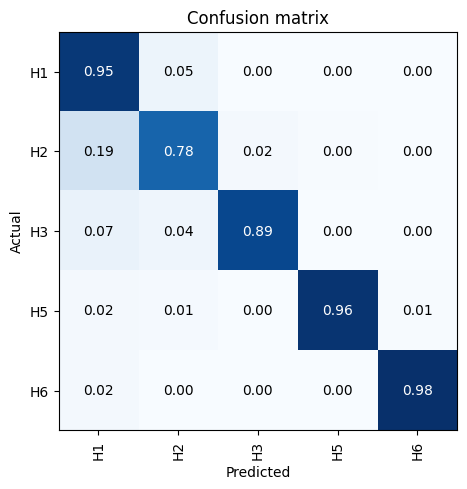

In [49]:
# show confusion matrix of predictions on the validation set
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)

ResNet34 performed better with higher accuracy across all classes compared to ViT Tiny and achieved an overall accuracy of **~93%**. The ViT Tiny model also seems to be more prone to overfitting, as evident from the high validation loss. The ViT Tiny model did surprisingly well considering that it has significantly fewer parameters than ResNet34.

I made this notebook to practice what I learnt in Lesson 1 of FastAI's [Practical Deep Learning for Coders](https://course.fast.ai/). Jeremy Howard's [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) notebooks and videos helped me a lot when working on this project.